In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [109]:
df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')

# Create copy to keep original data
songs = df.copy()

# Prints the first 5 rows
print(songs.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703               

In [110]:
# Prints data types of each column
print(songs.dtypes)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object


In [111]:
# Drop post-release and irrelevant features
features_to_remove = [
    'in_spotify_charts', 'in_apple_charts', 'in_shazam_charts',
    'in_deezer_charts', 'in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists',
    'track_name', 'artist(s)_name'
]

songs = songs.drop(columns=features_to_remove)

# Remove commas and convert 'streams' to numeric (coerce errors to NaN)
songs['streams'] = songs['streams'].replace(',', '', regex=True)

# Convert 'streams' to float and coerce errors to NaN
songs['streams'] = pd.to_numeric(songs['streams'], errors='coerce')

# The remaining features will be used for prediction
print(songs.columns)


Index(['artist_count', 'released_year', 'released_month', 'released_day',
       'streams', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%',
       'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%',
       'speechiness_%'],
      dtype='object')


In [112]:
# Check for any NaN values after conversion
print(songs.isnull().sum())

artist_count           0
released_year          0
released_month         0
released_day           0
streams                1
bpm                    0
key                   95
mode                   0
danceability_%         0
valence_%              0
energy_%               0
acousticness_%         0
instrumentalness_%     0
liveness_%             0
speechiness_%          0
dtype: int64


In [113]:
#Data Imputation
# Drop row with missing 'streams'
songs.dropna(subset=['streams'], inplace=True)

# Impute missing 'key' with the most frequent key
most_frequent_key = songs['key'].mode()[0]
songs['key'].fillna(most_frequent_key, inplace=True)

<ipython-input-113-1ebb84c30f3d>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  songs['key'].fillna(most_frequent_key, inplace=True)


In [114]:
# check null values again
print(songs.isnull().sum())

artist_count          0
released_year         0
released_month        0
released_day          0
streams               0
bpm                   0
key                   0
mode                  0
danceability_%        0
valence_%             0
energy_%              0
acousticness_%        0
instrumentalness_%    0
liveness_%            0
speechiness_%         0
dtype: int64


In [115]:
# Checks the number of 0's for numerical values
numerical_columns = songs.select_dtypes(include=['float64', 'int64']).columns  # Select numerical columns
zeros_count = (songs[numerical_columns] == 0).sum()  # Count zeros in numerical columns
print('\nZero Values in Numerical Columns:\n', zeros_count)


Zero Values in Numerical Columns:
 artist_count            0
released_year           0
released_month          0
released_day            0
streams                 0
bpm                     0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%         60
instrumentalness_%    865
liveness_%              0
speechiness_%           0
dtype: int64


In [116]:
# Check for duplicates
print('Duplicates Found: ', songs.duplicated().sum())

Duplicates Found:  0


In [117]:
# Feature Engineering
# Binary encoding for 'mode' (Major = 1, Minor = 0)
songs['mode'] = songs['mode'].map({'Major': 1, 'Minor': 0})

# Verify the transformation
print(songs['mode'].head())


0    1
1    1
2    1
3    1
4    0
Name: mode, dtype: int64


In [118]:
# --- Cyclic Encoding for 'key', 'released_month', and 'released_day' ---
# Encode 'key' as a numeric value to capture cyclic nature of musical notes (e.g., circular relationship)
key_mapping = {'A': 0, 'A#': 1, 'B': 2, 'C': 3, 'C#': 4, 'D': 5, 'D#': 6, 'E': 7, 'F': 8, 'F#': 9, 'G': 10, 'G#': 11}
songs['key_number'] = songs['key'].map(key_mapping)

# Apply sine and cosine transformations to capture cyclic patterns in 'key' (12 musical notes)
songs['key_sin'] = np.sin(2 * np.pi * songs['key_number'] / 12)
songs['key_cos'] = np.cos(2 * np.pi * songs['key_number'] / 12)

# Drop original 'key' and 'key_number' columns after encoding
songs.drop(columns=['key', 'key_number'], inplace=True)

# Encode 'released_month' and 'released_day' using sine and cosine to capture their cyclic nature (seasonality)
songs['month_sin'] = np.sin(2 * np.pi * songs['released_month'] / 12)  # Cyclic effect of months
songs['month_cos'] = np.cos(2 * np.pi * songs['released_month'] / 12)

# For 'released_day', capture daily cycles (e.g., weekday effects)
songs['day_sin'] = np.sin(2 * np.pi * songs['released_day'] / 31)  # Assuming 31 days in a month
songs['day_cos'] = np.cos(2 * np.pi * songs['released_day'] / 31)

# Drop original 'released_month' and 'released_day' columns after encoding
songs.drop(columns=['released_month', 'released_day'], inplace=True)

# Calculate age of song
current_year = 2024
songs['song_age'] = current_year - songs['released_year']

# Drop released_year
songs = songs.drop(columns=['released_year'])

In [119]:
print(songs[['song_age', 'streams']].corr())

          song_age   streams
song_age  1.000000  0.230803
streams   0.230803  1.000000


In [120]:
# Convert percentage columns to decimals
percentage_columns = ['danceability_%', 'energy_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'acousticness_%', 'valence_%']
songs[percentage_columns] = songs[percentage_columns] / 100

print(songs[percentage_columns].head())


   danceability_%  energy_%  instrumentalness_%  liveness_%  speechiness_%  \
0            0.80      0.83                0.00        0.08           0.04   
1            0.71      0.74                0.00        0.10           0.04   
2            0.51      0.53                0.00        0.31           0.06   
3            0.55      0.72                0.00        0.11           0.15   
4            0.65      0.80                0.63        0.11           0.06   

   acousticness_%  valence_%  
0            0.31       0.89  
1            0.07       0.61  
2            0.17       0.32  
3            0.11       0.58  
4            0.14       0.23  


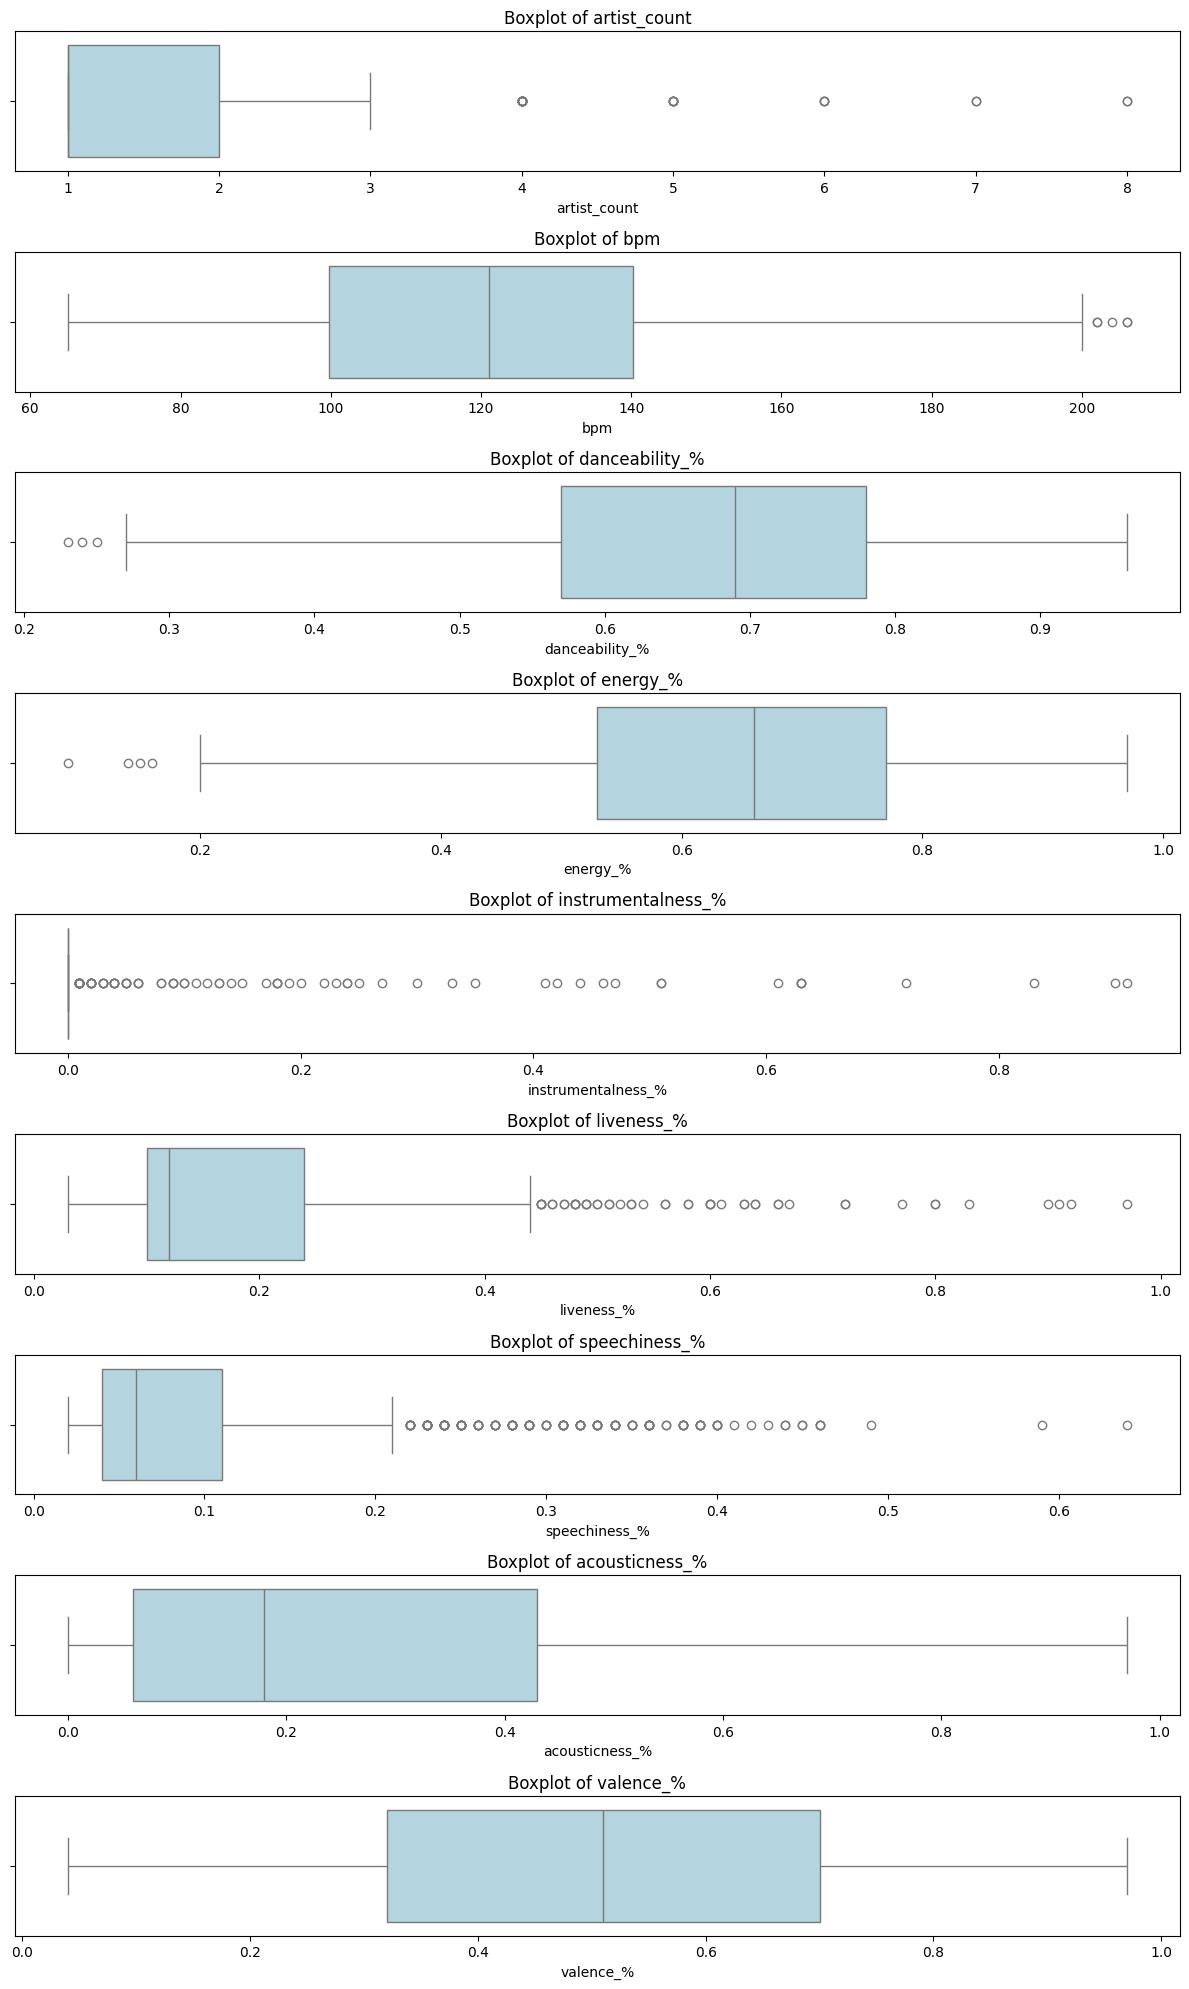

In [121]:
# Boxplots before capping
# Create individual boxplots for each numerical feature
numerical_features = ['artist_count', 'bpm'] + percentage_columns

plt.figure(figsize=(12, 20))

# Loop through the features to create individual boxplots
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=songs[feature], color='lightblue')
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()  # Ensures plots do not overlap

plt.show()


In [122]:
# Cap outliers at 1st and 99th percentiles
for col in numerical_features:
    lower_cap = songs[col].quantile(0.01)
    upper_cap = songs[col].quantile(0.99)
    songs[col] = songs[col].clip(lower=lower_cap, upper=upper_cap)

# Display the capped data
print(songs[numerical_features].describe())


       artist_count         bpm  danceability_%    energy_%  \
count    952.000000  952.000000      952.000000  952.000000   
mean       1.543067  122.475840        0.670021    0.643246   
std        0.820501   27.696444        0.145075    0.163678   
min        1.000000   73.510000        0.310000    0.240000   
25%        1.000000   99.750000        0.570000    0.530000   
50%        1.000000  121.000000        0.690000    0.660000   
75%        2.000000  140.250000        0.780000    0.770000   
max        5.000000  188.490000        0.930000    0.940000   

       instrumentalness_%  liveness_%  speechiness_%  acousticness_%  \
count          952.000000  952.000000     952.000000      952.000000   
mean             0.013746    0.180814       0.100860        0.270546   
std              0.066930    0.130382       0.096844        0.259394   
min              0.000000    0.050000       0.030000        0.000000   
25%              0.000000    0.100000       0.040000        0.060000   


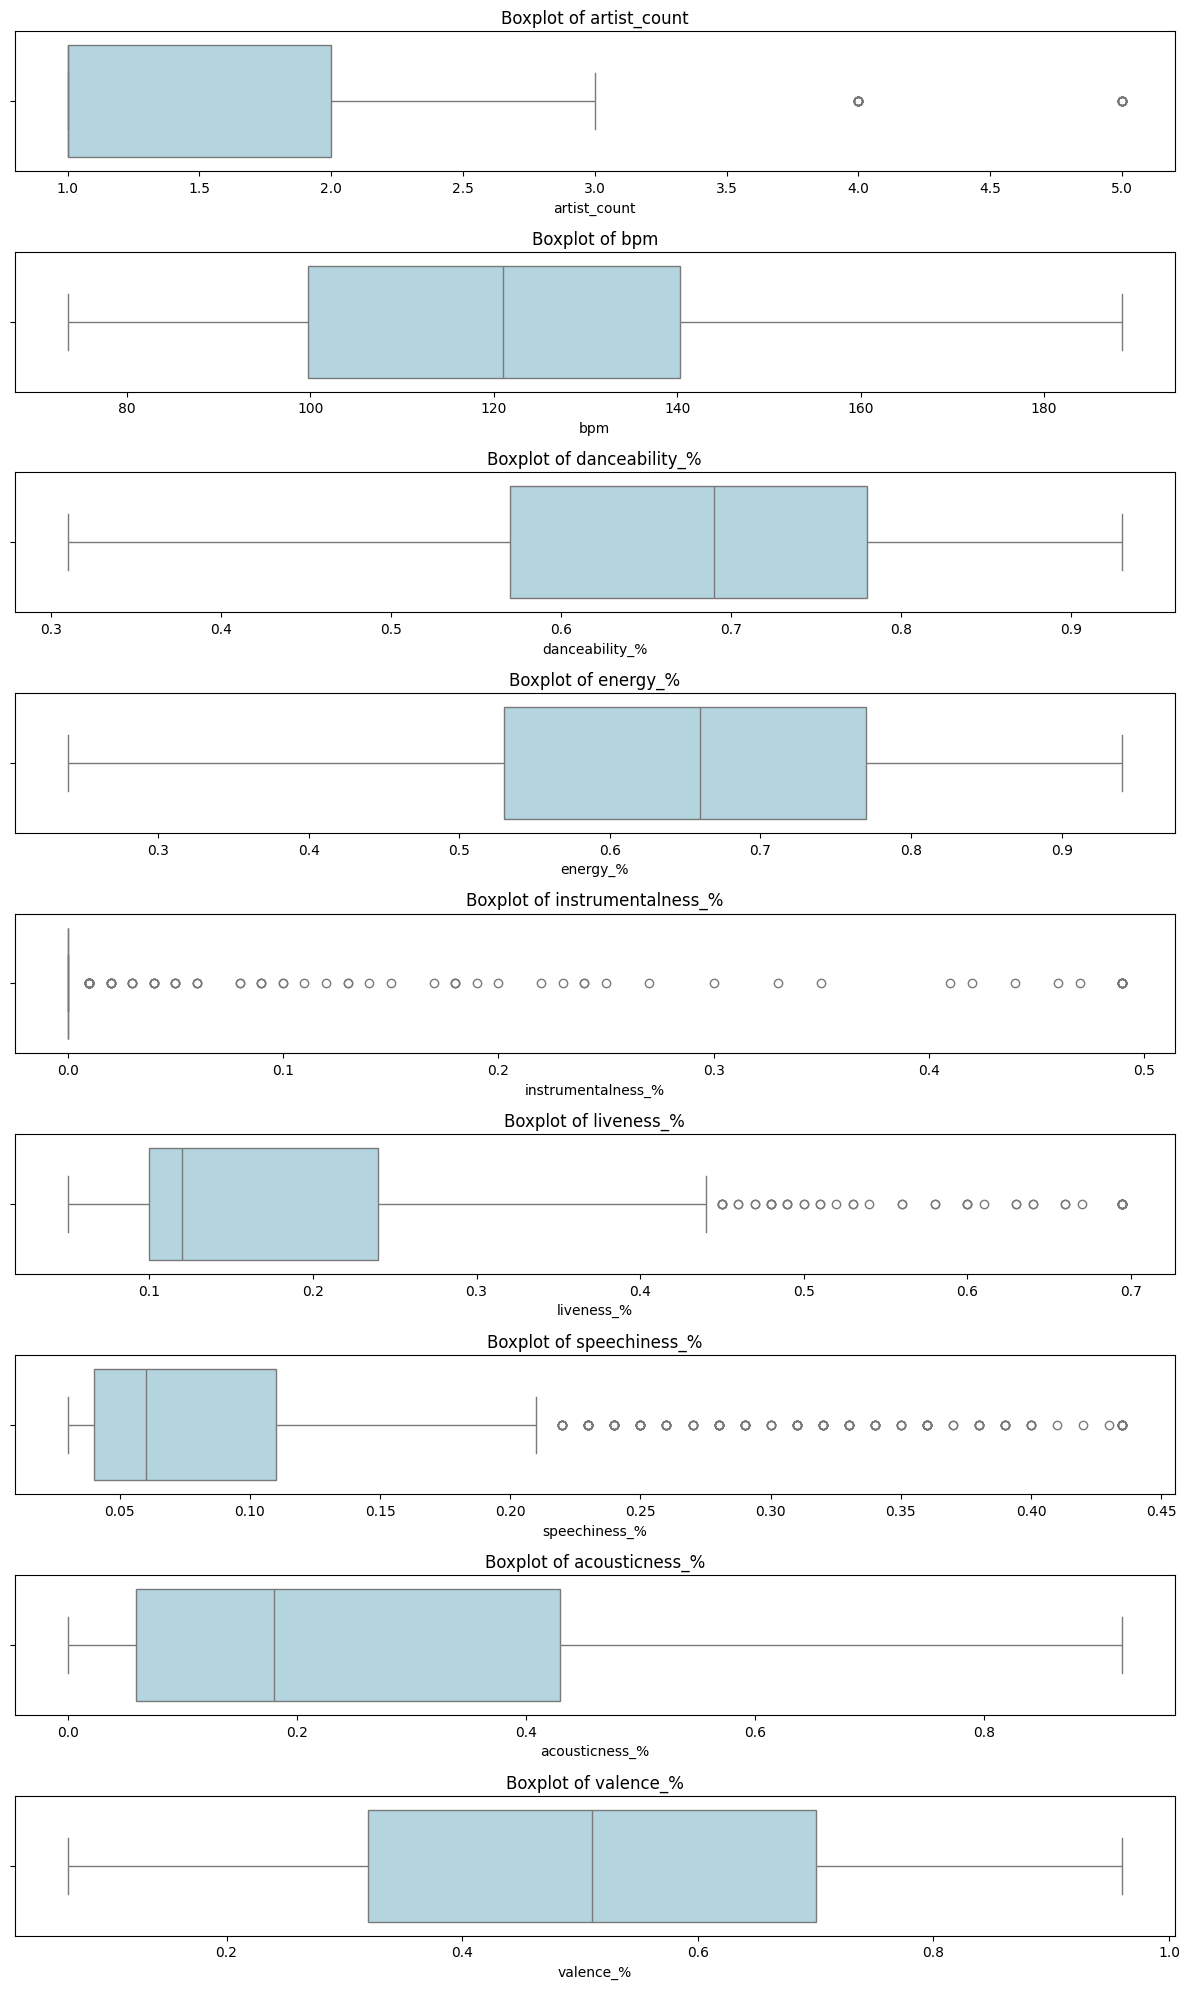

In [123]:
# Boxplots after capping
plt.figure(figsize=(12, 20))

# Loop through the features to create individual boxplots
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=songs[feature], color='lightblue')
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()

# Display the plots
plt.show()


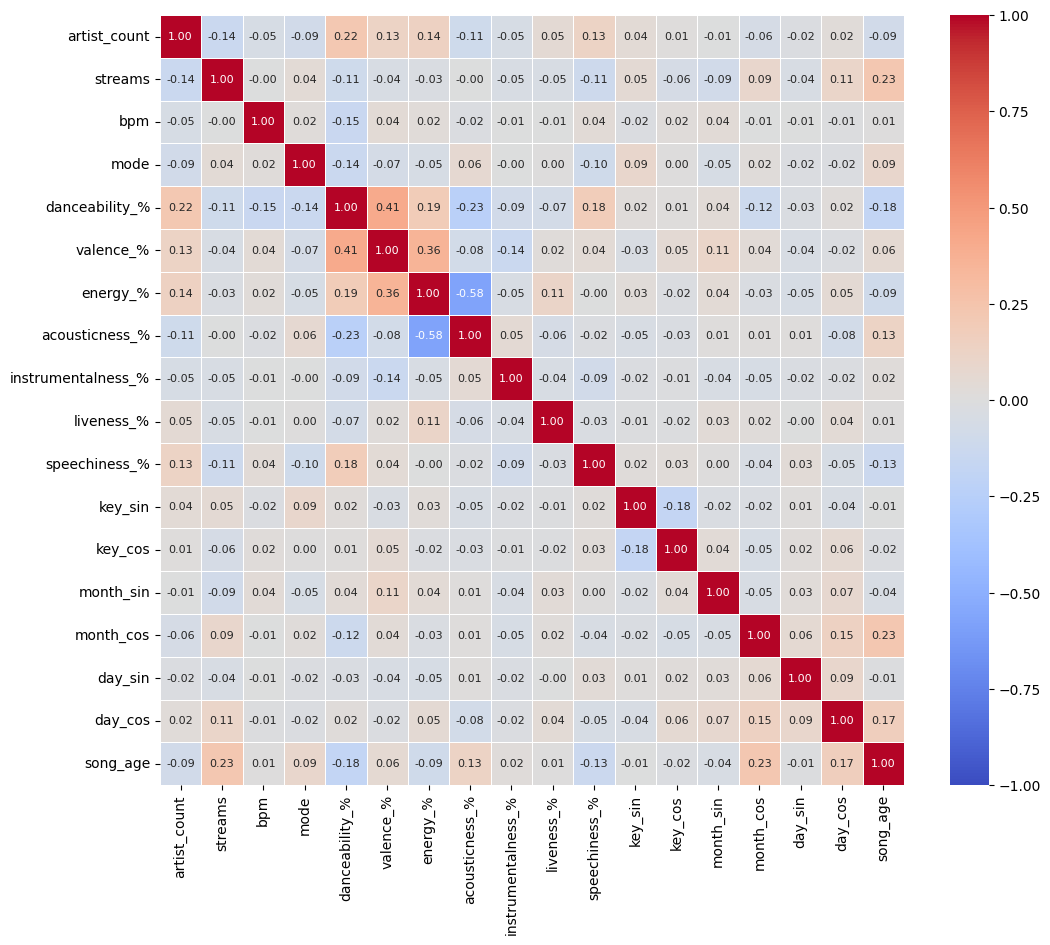

acousticness_%  energy_%         -0.575134
energy_%        acousticness_%   -0.575134
danceability_%  valence_%         0.410404
valence_%       danceability_%    0.410404
                energy_%          0.358262
energy_%        valence_%         0.358262
acousticness_%  danceability_%   -0.234427
danceability_%  acousticness_%   -0.234427
streams         song_age          0.230803
song_age        streams           0.230803
dtype: float64


In [124]:
# Correlation Calculations
# Get Numeric Values
songs_numeric_columns = songs.select_dtypes(include=[np.number])

# Compute the Correlation Matrix
corr_matrix = songs_numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, vmin=-1, vmax=1, linewidths=0.5)
plt.show()

# Prints Top 10 strongest correlations
corr_pairs = corr_matrix.unstack()
sorted_corr = corr_pairs.sort_values(key=abs, ascending=False)

# Drop self-correlations by filtering out correlations of 1
sorted_corr = sorted_corr[sorted_corr != 1]
print(sorted_corr.head(10))

In [125]:
# Normalization of Data
# Log transformation for 'streams' to reduce skewness
songs['streams'] = np.log1p(songs['streams'])

# Initialize the scaler
scaler = MinMaxScaler()
columns_to_normalize = ['streams', 'artist_count', 'bpm'] + percentage_columns

# Fit and transform the selected columns
songs[columns_to_normalize] = scaler.fit_transform(songs[columns_to_normalize])

print(songs[columns_to_normalize].head())
songs[columns_to_normalize].head()


    streams  artist_count       bpm  danceability_%  energy_%  \
0  0.768533          0.25  0.447817        0.790323  0.842857   
1  0.764582          0.00  0.160811        0.645161  0.714286   
2  0.767838          0.00  0.560880        0.322581  0.414286   
3  0.891451          0.00  0.839189        0.387097  0.685714   
4  0.822617          0.00  0.613063        0.548387  0.800000   

   instrumentalness_%  liveness_%  speechiness_%  acousticness_%  valence_%  
0                 0.0    0.046548       0.024697        0.336957   0.921779  
1                 0.0    0.077580       0.024697        0.076087   0.608895  
2                 0.0    0.403413       0.074092        0.184783   0.284836  
3                 0.0    0.093095       0.296369        0.119565   0.575372  
4                 1.0    0.093095       0.074092        0.152174   0.184266  


,streams,artist_count,bpm,danceability_%,energy_%,instrumentalness_%,liveness_%,speechiness_%,acousticness_%,valence_%
0,0.768533,0.25,0.447817,0.790323,0.842857,0.0,0.046548,0.024697,0.336957,0.921779
1,0.764582,0.00,0.160811,0.645161,0.714286,0.0,0.077580,0.024697,0.076087,0.608895
2,0.767838,0.00,0.560880,0.322581,0.414286,0.0,0.403413,0.074092,0.184783,0.284836
3,0.891451,0.00,0.839189,0.387097,0.685714,0.0,0.093095,0.296369,0.119565,0.575372
4,0.822617,0.00,0.613063,0.548387,0.800000,1.0,0.093095,0.074092,0.152174,0.184266


In [126]:
# Save the normalized data to a new CSV file
songs.to_csv('preprocessed_spotify_data_for_prediction.csv', index=False)